# Install required libraries
To install the required libraries from the requirements file, use the following command:
"pip install -r requirements.txt"

# 0. Initialization

In [206]:
import numpy as np # a library for numerical computations and handling arrays
import pandas as pd #  a library for data manipulation and analysis, often used for handling tabular data

# Visualisation Library
import matplotlib.pyplot as plt # module for data visualization through plots and charts
import seaborn as sns # a data visualization library built on Matplotlib, offering advanced plotting functions and attractive visual styles
import matplotlib.ticker as ticker
# Classification continous
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Classification Categorial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

# Processing Classification
from sklearn.model_selection import train_test_split
from sklearn import metrics

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Collecte the Data

In [207]:
# Load the dataset from the specified path
data = pd.read_csv("../data/G3_immobiliers.csv")

# 2. Data Cleaning and Preparation

In [208]:
# Display the first 10 rows of the dataset to understand its structure
data.head(10)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
0,2022-1343146,2022-02-04,1,Vente,420000.0,NaN,NaN,LA CADISCIE,B009,81220.0,...,NaN,NaN,T,terres,NaN,NaN,1215.0,1.950729,43.64992,0000A
1,2022-1343521,2022-01-28,1,Vente,1500.0,NaN,NaN,SERRO,B168,81260.0,...,NaN,NaN,P,prés,NaN,NaN,1000.0,2.5195,43.618791,0000C
2,2022-1343592,2022-01-28,2,Vente,105000.0,NaN,NaN,PUECH ROUGE,B026,81170.0,...,NaN,NaN,P,prés,NaN,NaN,3900.0,1.896586,44.044786,0000A
3,2022-1343732,2022-02-10,1,Vente,5000.0,NaN,NaN,FOURMENTAL,B029,81300.0,...,NaN,NaN,T,terres,NaN,NaN,2770.0,2.031586,43.697737,0000B
4,2022-1343732,2022-02-10,1,Vente,5000.0,NaN,NaN,FOURMENTAL,B029,81300.0,...,NaN,NaN,T,terres,NaN,NaN,591.0,2.031218,43.697683,0000B
5,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,1762.0,1.667288,43.859966,0000C
6,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,P,prés,NaN,NaN,5505.0,1.66712,43.85981,0000C
7,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,18.0,1.667785,43.859678,0000C
8,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,70.0,1.667777,43.859631,0000C
9,2022-1343779,2022-02-11,1,Vente,173000.0,NaN,NaN,BAURUNE,B003,81120.0,...,NaN,NaN,T,terres,NaN,NaN,2022.0,2.087579,43.805298,0000D


In [209]:
# Display dataset information including column names, data types, and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146215 entries, 0 to 146214
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   id_mutation                   146215 non-null  object
 1   date_mutation                 146215 non-null  object
 2   numero_disposition            146215 non-null  object
 3   nature_mutation               146215 non-null  object
 4   valeur_fonciere               145482 non-null  object
 5   adresse_numero                67801 non-null   object
 6   adresse_suffixe               2927 non-null    object
 7   adresse_nom_voie              146142 non-null  object
 8   adresse_code_voie             146143 non-null  object
 9   code_postal                   146143 non-null  object
 10  code_commune                  146215 non-null  object
 11  nom_commune                   146215 non-null  object
 12  code_departement              146215 non-null  object
 13 

In [210]:
# Get statistical summaries of numerical columns
data.describe()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
count,146215,146215,146215,146215,145482.0,67801.0,2927,146142,146143,146143.0,...,42035.0,63503.0,134685,134685,20624,20624,134685.0,145142.000000,145142.00000,146215
unique,25492,891,15,6,7244.0,2702.0,11,12527,2290,99.0,...,945.0,32.0,22,22,27,27,14490.0,59856.000000,59338.00000,303
top,2022-1349012,2022-07-12,1,Vente,150000.0,1.0,B,LE VILLAGE,B020,81100.0,...,80.0,0.0,S,sols,FRICH,Friche,500.0,2.773587,43.64924,0000B
freq,480,933,102435,142495,1210.0,1954.0,2131,707,1016,8966.0,...,797.0,18640.0,55206,55206,5250,5250,2690.0,171.000000,171.00000,19936


In [211]:
# Check the total number of missing values in each column
data.isnull().sum()

id_mutation                          0
date_mutation                        0
numero_disposition                   0
nature_mutation                      0
valeur_fonciere                    733
adresse_numero                   78414
adresse_suffixe                 143288
adresse_nom_voie                    73
adresse_code_voie                   72
code_postal                         72
code_commune                         0
nom_commune                          0
code_departement                     0
ancien_code_commune             146205
ancien_nom_commune              146205
id_parcelle                          0
ancien_id_parcelle              146205
numero_volume                   145960
lot1_numero                     135814
lot1_surface_carrez             142818
lot2_numero                     143440
lot2_surface_carrez             145473
lot3_numero                     145396
lot3_surface_carrez             145931
lot4_numero                     146035
lot4_surface_carrez      

In [212]:
# Drop unnecessary columns that are not useful for predictive modeling
df_data = data[["valeur_fonciere", "date_mutation",  # Price and transaction date
    "code_postal", "code_commune", "nom_commune", "code_departement",  # Location
    "longitude", "latitude",  # GPS coordinates
    "type_local", "surface_reelle_bati", "nombre_pieces_principales",  # Goods characteristics
    "surface_terrain", "nature_culture"  # Land characteristics
]]

In [213]:
# Convert "valeur_fonciere" column to numeric, forcing errors to NaN
df_data["valeur_fonciere"] = pd.to_numeric(df_data["valeur_fonciere"], errors="coerce")
# Remove rows where "valeur_fonciere" is missing
df_data = df_data.dropna(subset=["valeur_fonciere"])

In [214]:
# Convert "surface_reelle_bati" column to numeric, forcing errors to NaN
df_data["surface_reelle_bati"] = pd.to_numeric(df_data["surface_reelle_bati"], errors="coerce")
# Remove rows where "surface_reelle_bati" is missing
df_data = df_data.dropna(subset=["surface_reelle_bati"])

In [215]:
# Remove rows with more than 50% missing values
df_data = df_data.dropna(thresh=len(df_data.columns) * 0.5)

In [216]:
# Fill missing values in numerical columns with the median
# Convert numerical columns to float type (forcing errors to NaN)
cols_num = ["surface_reelle_bati", "surface_terrain", "nombre_pieces_principales", "valeur_fonciere"]
for col in cols_num:
    df_data[col] = pd.to_numeric(df_data[col], errors="coerce")  # Convert to float
    df_data[col] = df_data[col].fillna(df_data[col].median())  # Replace NaN with median

In [217]:
# Fill missing values in categorical columns with "Unknown"
cols_cat = ["type_local", "nature_culture"]
for col in cols_cat:
    df_data[col] = df_data[col].fillna("Unknown")

In [218]:
# Convert categorical variables into dummy/indicator variables (One-Hot Encoding)
df_data = pd.get_dummies(df_data, columns=["type_local", "nature_culture"], drop_first=True)

In [219]:
# Display the first 10 rows after cleaning and transformation
df_data.head(10)

,valeur_fonciere,date_mutation,code_postal,code_commune,nom_commune,code_departement,longitude,latitude,surface_reelle_bati,nombre_pieces_principales,...,nature_culture_peupleraies,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vergers,nature_culture_vignes
60,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,28.0,3.0,...,False,False,False,False,False,False,True,False,False,False
61,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,666.0,0.0,...,False,False,False,False,False,False,True,False,False,False
62,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,2.0,...,False,False,False,False,False,False,True,False,False,False
63,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,2.0,...,False,False,False,False,False,False,True,False,False,False
64,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,2.0,...,False,False,False,False,False,False,True,False,False,False
65,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,2.0,...,False,False,False,False,False,False,True,False,False,False
66,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,2.0,...,False,False,False,False,False,False,True,False,False,False
67,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,3.0,...,False,False,False,False,False,False,True,False,False,False
68,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,3.0,...,False,False,False,False,False,False,True,False,False,False
69,185000.0,2022-05-16,81320.0,81193,Nages,81,2.773587,43.64924,29.0,3.0,...,False,False,False,False,False,False,True,False,False,False


In [220]:
# Display dataset information after cleaning and transformation
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41956 entries, 60 to 146212
Data columns (total 28 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   valeur_fonciere                                      41956 non-null  float64
 1   date_mutation                                        41956 non-null  object 
 2   code_postal                                          41956 non-null  object 
 3   code_commune                                         41956 non-null  object 
 4   nom_commune                                          41956 non-null  object 
 5   code_departement                                     41956 non-null  object 
 6   longitude                                            41624 non-null  object 
 7   latitude                                             41624 non-null  object 
 8   surface_reelle_bati                                  41956 non-null  

# 3. Distribution des Prix Immobiliers

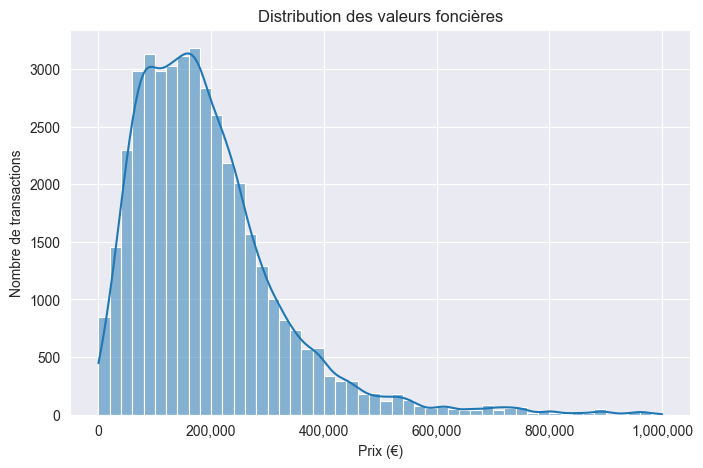

In [221]:
# Distribution des prix immobiliers
plt.figure(figsize=(8, 5))
sns.histplot(df_data[df_data.valeur_fonciere <= 1e6].valeur_fonciere, bins=50, kde=True)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de transactions")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))
plt.show()

# 4. Visualisation des Relations entre Surface et Prix par Type de Bien

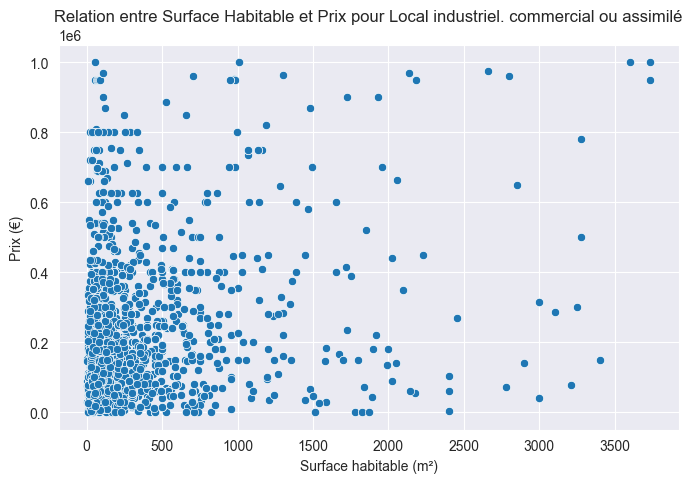

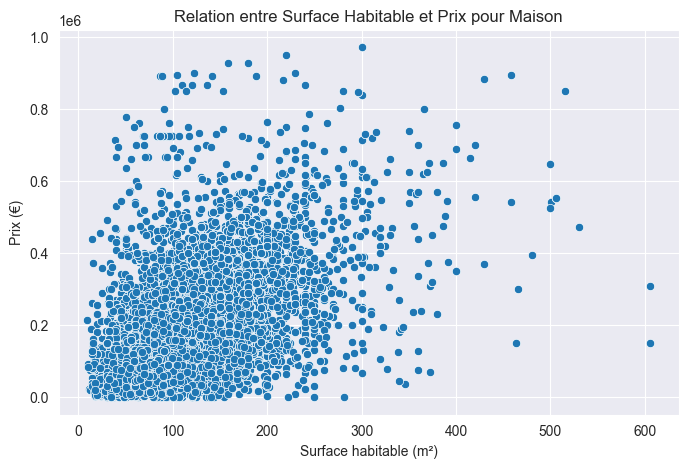

In [222]:
# Obtenir les types de biens uniques
unique_types = df_data.columns[df_data.columns.str.startswith("type_local_")]

# Créer un graphique distinct pour chaque type de bien
for type_col in unique_types:
    type_name = type_col.replace("type_local_", "")  # Extraire le nom du type de bien
    subset = df_data[(df_data[type_col] == 1) & (df_data.surface_reelle_bati <= 4000) & (df_data.valeur_fonciere <= 1e6)]  # Filtrer les données

    # Vérifier si le sous-ensemble contient des données
    if not subset.empty:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=subset.surface_reelle_bati, y=subset.valeur_fonciere)
        plt.title(f"Relation entre Surface Habitable et Prix pour {type_name}")
        plt.xlabel("Surface habitable (m²)")
        plt.ylabel("Prix (€)")
        plt.show()

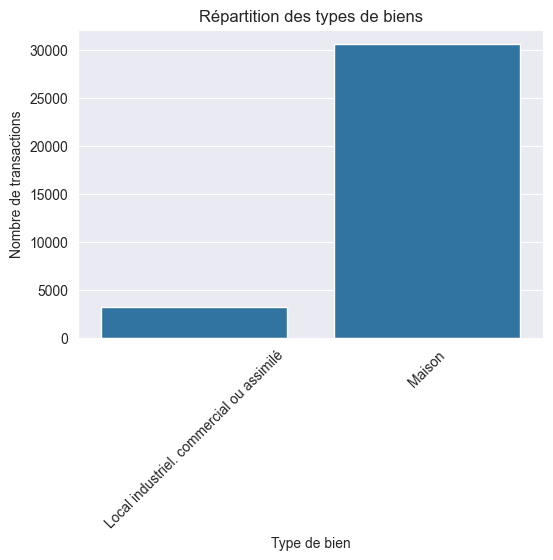

In [223]:
# Répartition des types de biens
plt.figure(figsize=(6, 4))

# Extraire les noms des types de biens
type_local_columns = [col for col in df_data.columns if col.startswith("type_local_")]

# Compter le nombre d'occurrences pour chaque type de bien
type_counts = {col.replace("type_local_", ""): df_data[col].sum() for col in type_local_columns}

# Créer un DataFrame pour la visualisation
df_type_counts = pd.DataFrame.from_dict(type_counts, orient="index", columns=["count"]).reset_index()
df_type_counts.rename(columns={"index": "type_local"}, inplace=True)

# Tracer le graphique
sns.barplot(x="type_local", y="count", data=df_type_counts)
plt.title("Répartition des types de biens")
plt.xticks(rotation=45)
plt.xlabel("Type de bien")
plt.ylabel("Nombre de transactions")
plt.show()
